## Week 3 HW: Box Jenkins Models
### Jingwen Li

In [267]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from scipy import stats
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

## Part 1 – Regression Analysis


### 1. Perform EDA (numerical, visual, descriptive)

In [268]:
data = pd.read_csv('hw3_data.csv', index_col=0, parse_dates=True)
data

,gdp,urate
date,,
1948-01-01,265.742,3.4
1948-04-01,272.567,3.9
1948-07-01,279.196,3.6
1948-10-01,280.366,3.7
1949-01-01,275.034,4.3
...,...,...
2019-10-01,21747.394,3.6
2020-01-01,21561.139,3.5
2020-04-01,19520.114,14.8


    Numerical

In [269]:
data.describe()

,gdp,urate
count,292.000000,292.00000
mean,6481.725808,5.77911
std,6487.790355,1.74368
min,265.742000,2.60000
25%,802.669250,4.50000
50%,4046.925500,5.60000
75%,11011.904000,6.82500
max,21747.394000,14.80000


    Visual

<AxesSubplot: xlabel='date'>

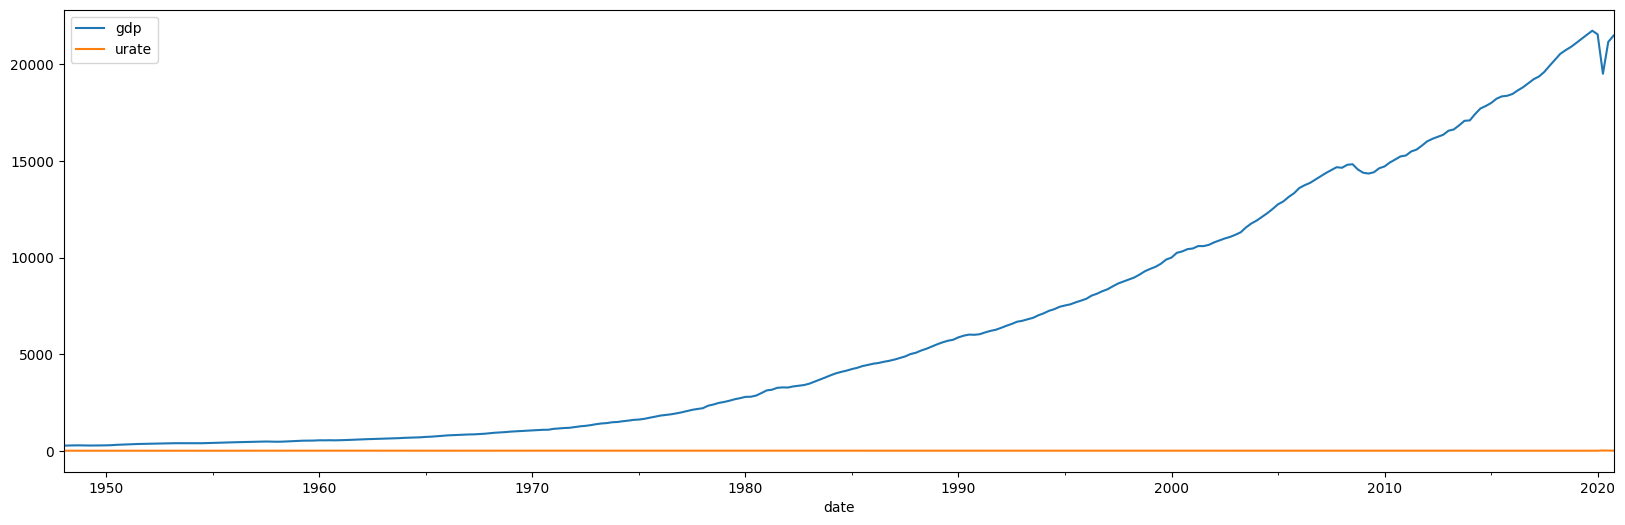

In [270]:
data.plot(figsize=(20, 6))

<AxesSubplot: xlabel='date'>

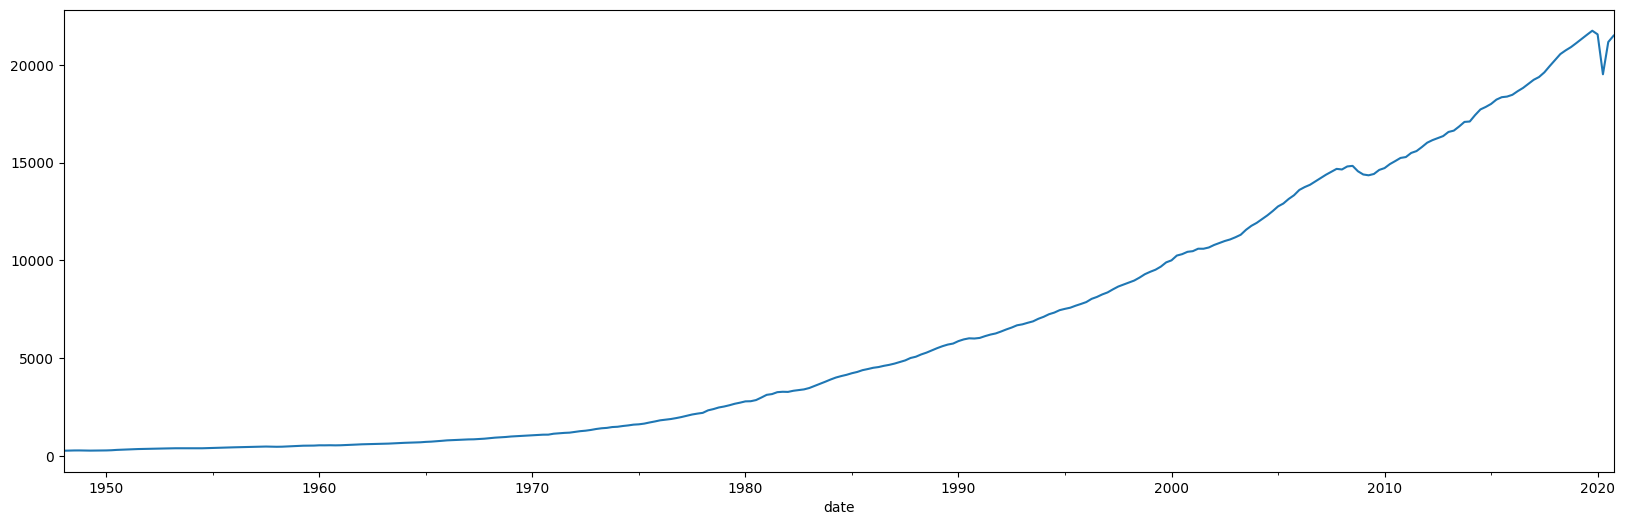

In [271]:
data['gdp'].plot(figsize=(20, 6))

<AxesSubplot: xlabel='date'>

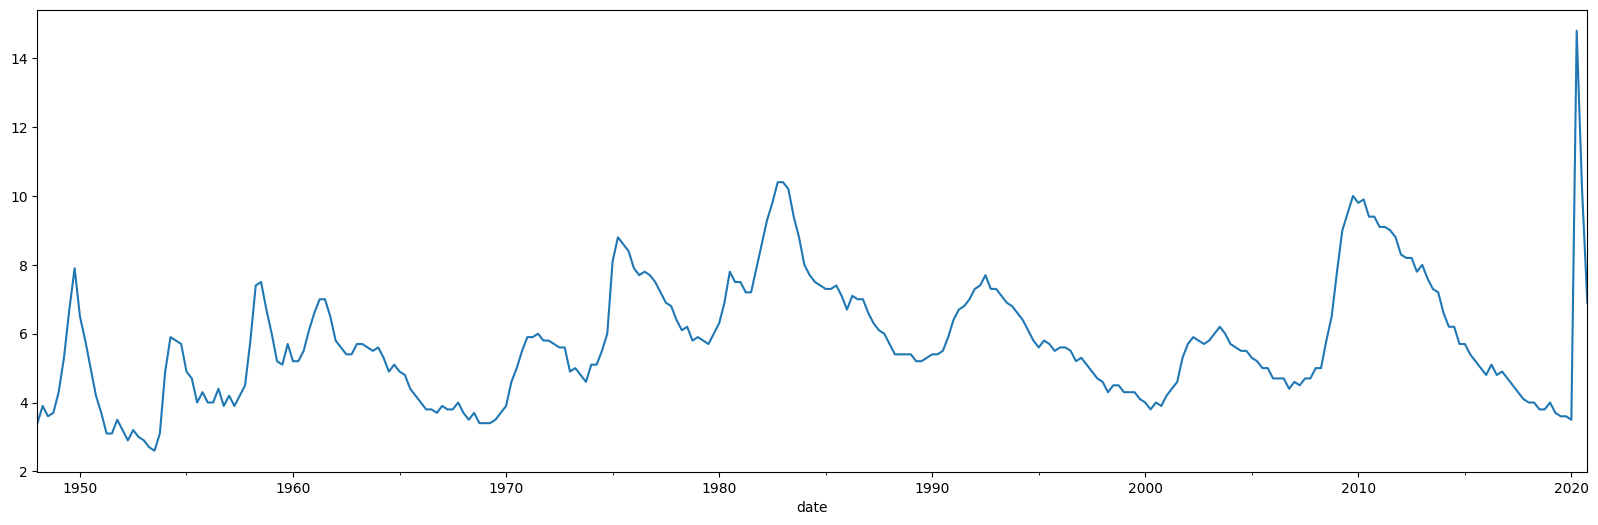

In [272]:
data['urate'].plot(figsize=(20, 6))

    Descriptive

The given dataset contains information about the GDP and unemployment rate in the United States, which is quarterly data and covers the time period from 1948 to 2020. The dataset includes 292 observations for each variable.

Upon analyzing the dataset, we observe that GDP exhibits an upward trend over the years, with some fluctuations around the year 2020. On the other hand, the unemployment rate has been fluctuating throughout the time frame, with a peak in the year 2020.

This information gives us a better understanding of the economic trends in the US over the past few decades, as it helps us understand the fluctuations in GDP and the unemployment rate, and their relationship over time. It can also be useful in predicting future trends and patterns in the economy, and help inform policy decisions.

### 2. What is Okun’s Law? Does our dataset fit what we would expect to see? Why or why not?

    Okun's Law:

Okun's Law is an empirical relationship between the change in the unemployment rate and the change in real Gross Domestic Product (GDP). It states that in the short run, there is an inverse relationship between the two variables: a 1% increase in GDP will lead to a decrease in the unemployment rate by a certain percentage, typically estimated to be around 2%. The law is named after economist Arthur Okun, who first proposed the relationship in the 1960s. The law suggests that in order to lower the unemployment rate, an economy needs to grow at a certain rate above its potential growth rate.

In [273]:
# Calculate quarterly percentage change in GDP
data['gdp pct change'] = data['gdp'].pct_change(periods=1) * 100

# Calculate quarterly change in unemployment rate
data['urate change'] = data['urate'].diff()

In [274]:
#filter to keep only GDP increase
OkunsLaw = data[data['gdp pct change'] > 0]
OkunsLaw

,gdp,urate,gdp pct change,urate change
date,,,,
1948-04-01,272.567,3.9,2.568281,0.5
1948-07-01,279.196,3.6,2.432063,-0.3
1948-10-01,280.366,3.7,0.419060,0.1
1949-07-01,272.889,6.7,0.566794,1.4
1950-01-01,280.828,6.5,3.769395,-1.4
...,...,...,...,...
2019-04-01,21329.877,3.7,1.016173,-0.3
2019-07-01,21540.325,3.6,0.986635,-0.1
2019-10-01,21747.394,3.6,0.961309,0.0


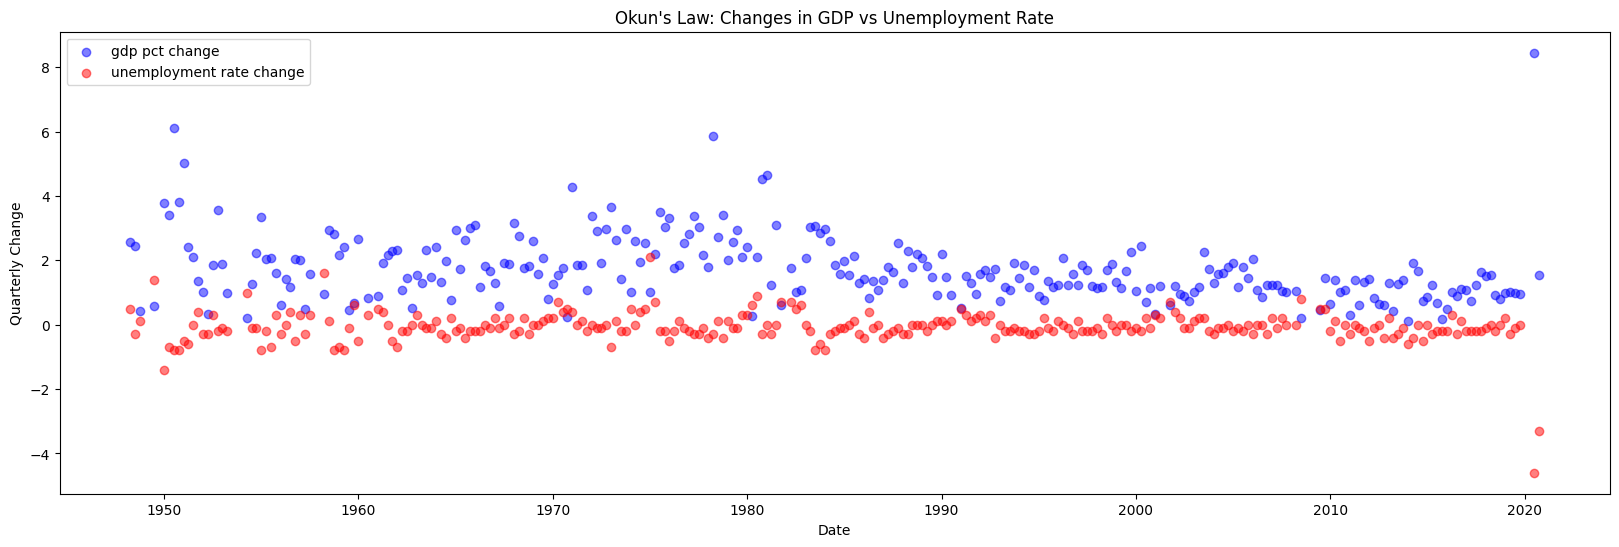

In [275]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.scatter(OkunsLaw.index, OkunsLaw['gdp pct change'], color='blue', alpha=0.5, label = 'gdp pct change')
ax.scatter(OkunsLaw.index, OkunsLaw['urate change'], color='red', alpha=0.5, label = 'unemployment rate change')

# Add a title and axis labels
ax.set_title("Okun's Law: Changes in GDP vs Unemployment Rate")
ax.set_xlabel("Date")
ax.set_ylabel("Quarterly Change")
ax.legend()

plt.show()

    Does our dataset fit Okun's law? Why or why not?

Based on the scatter plot, we can see a negative relationship between GDP percent change and unemployment rate change. However, to determine if our dataset satisfies Okun's Law, we would expect to see a stronger relationship, with the red dots (unemployment rate change) scattered further from 0 than the blue dots (GDP percent change). From the plot, it appears that the blue dots are more spread out than the red dots, indicating that there may be a weaker relationship between the two variables and our dataset may not fully satisfy Okun's Law.

### 3. Create a column that shows GDP change as a percentage and a column that shows UE rate as a change in percentage points. For date 4/1/1948 GDP change = 2.568, UE diff = 0.5

In [276]:
data = data.dropna()
data

,gdp,urate,gdp pct change,urate change
date,,,,
1948-04-01,272.567,3.9,2.568281,0.5
1948-07-01,279.196,3.6,2.432063,-0.3
1948-10-01,280.366,3.7,0.419060,0.1
1949-01-01,275.034,4.3,-1.901800,0.6
1949-04-01,271.351,5.3,-1.339107,1.0
...,...,...,...,...
2019-10-01,21747.394,3.6,0.961309,0.0
2020-01-01,21561.139,3.5,-0.856447,-0.1
2020-04-01,19520.114,14.8,-9.466221,11.3


### 4. Split into Train/test ( ) and create a scatterplot, verifying the negative relationship in Okun’s law.

    Split into Train/test

In [277]:
# Set the split point
train, test = train_test_split(data, test_size =0.25, shuffle=False)
X_train = train['gdp pct change'].to_frame()
y_train  = train['urate change'].to_frame()

X_test = test['gdp pct change'].to_frame()
y_test = test['urate change'].to_frame()

In [278]:
train

,gdp,urate,gdp pct change,urate change
date,,,,
1948-04-01,272.567,3.9,2.568281,0.5
1948-07-01,279.196,3.6,2.432063,-0.3
1948-10-01,280.366,3.7,0.419060,0.1
1949-01-01,275.034,4.3,-1.901800,0.6
1949-04-01,271.351,5.3,-1.339107,1.0
...,...,...,...,...
2001-07-01,10596.294,4.6,-0.014418,0.2
2001-10-01,10660.294,5.3,0.603985,0.7
2002-01-01,10788.952,5.7,1.206890,0.4


In [279]:
test.head(5)

,gdp,urate,gdp pct change,urate change
date,,,,
2002-10-01,11071.463,5.7,0.722449,-0.1
2003-01-01,11183.507,5.8,1.012007,0.1
2003-04-01,11312.875,6.0,1.156775,0.2
2003-07-01,11567.326,6.2,2.249216,0.2
2003-10-01,11769.275,6.0,1.745857,-0.2


    Scatter Plot

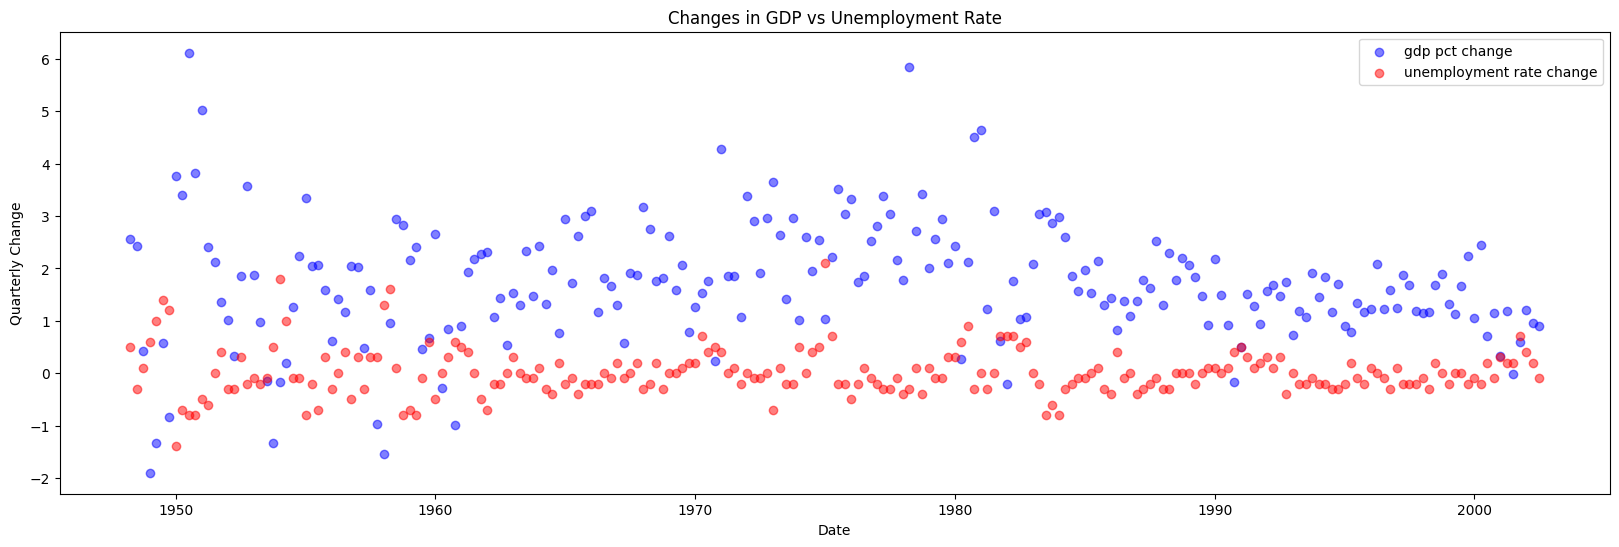

In [280]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.scatter(train.index, X_train, color='blue', alpha=0.5, label = 'gdp pct change')
ax.scatter(train.index, y_train, color='red', alpha=0.5, label = 'unemployment rate change')

# Add a title and axis labels
ax.set_title("Changes in GDP vs Unemployment Rate")
ax.set_xlabel("Date")
ax.set_ylabel("Quarterly Change")
ax.legend()

plt.show()

    Verifying negative relationship

In [281]:
train.corr()

,gdp,urate,gdp pct change,urate change
gdp,1.000000,0.117390,-0.151351,-0.031490
urate,0.117390,1.000000,0.112779,0.127573
gdp pct change,-0.151351,0.112779,1.000000,-0.528613
urate change,-0.031490,0.127573,-0.528613,1.000000


corr = -0.528

### 5. Fit a linear model on the Training set. State Okun’s law using your data e.g. interpret the coefficients.


    Fit a linear model

In [282]:
# Create a linear regression object
model = LinearRegression()

model.fit(X_train, y_train)

# Fit the model to the training data
model.fit(X_train, y_train)

print('Formula: y = {:.2f} + ({:.2f}) x'.format(model.intercept_[0], model.coef_[0][0]))

Formula: y = 0.37 + (-0.21) x


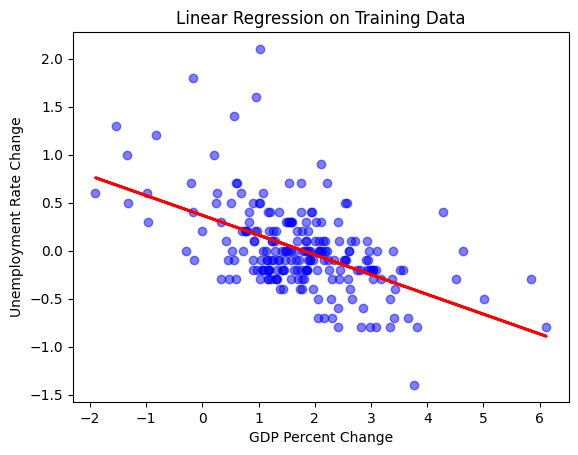

In [283]:
# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Plot the linear regression line on the training data
plt.scatter(X_train, y_train, color='blue', alpha=0.5)
plt.plot(X_train, y_train_pred, color='red', linewidth=2)
plt.title("Linear Regression on Training Data")
plt.xlabel("GDP Percent Change")
plt.ylabel("Unemployment Rate Change")
plt.show()

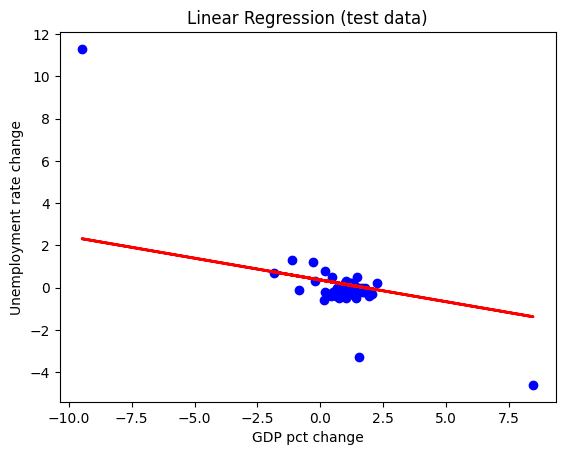

In [284]:
y_pred = model.predict(X_test)

plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('GDP pct change')
plt.ylabel('Unemployment rate change')
plt.title("Linear Regression (test data)")
plt.show()

    State Okun’s law using your data e.g. interpret the coefficients.

The linear model we obtained from the training data is y = 0.37 - 0.21 x. This indicates that for every 1% increase in GDP, we can expect approximately a 0.21% decrease in the unemployment rate. This estimate is different from the 2% decrease suggested by Okun's Law. Therefore, our dataset does not appear to satisfy Okun's Law.

### 6. How can we use this model to predict level of GDP dollars in the future? What will we need, what are the resulting limitations?

To use this linear model to predict the level of GDP dollars in the future, we need to obtain the future values of the predictor variable, i.e., the change in unemployment rate or expected unemployment rate. We can then use the model equation to predict the corresponding percentage change in the GDP, and apply it to the current level of GDP to obtain the predicted future level of GDP dollars.

However, there are several limitations to using this model for prediction. Firstly, the linear relationship between the percentage change in GDP and the change in unemployment rate may not hold in the future, especially if there are significant changes in the economic conditions or policies. Secondly, the accuracy of the model predictions depends on the accuracy of the future values of the predictor variable, which may be subject to uncertainty and errors. Thirdly, the model assumes that the relationship between the percentage change in GDP and the change in unemployment rate is linear, which may not be accurate in all situations.

Overall, while this model can provide some insights into the relationship between GDP and unemployment rate, it should be used with caution and in conjunction with other economic indicators and forecasts.

## Part 2 – Box Jenkins model for GDP

### 1. Perform transformations or differencing until you can visually and statistically confirm stationarity on training set. Summarize the changes to your time series.

    Transformationa and differencing

<AxesSubplot: xlabel='date'>

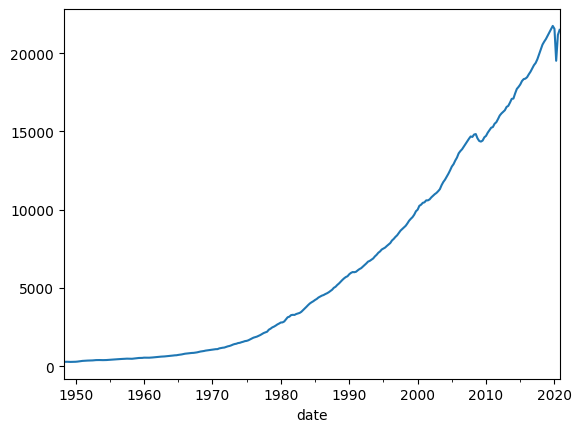

In [285]:
GDP = data['gdp']
GDP.plot()

In [286]:
trans_data, lambda_val = stats.boxcox(GDP)
trans_data = pd.Series(trans_data)

In [287]:
trans_1diff_data = (trans_data-trans_data.shift()).iloc[1:]
trans_2diff_data = (trans_1diff_data-trans_1diff_data.shift()).iloc[1:]

    Check stationarity

<AxesSubplot: >

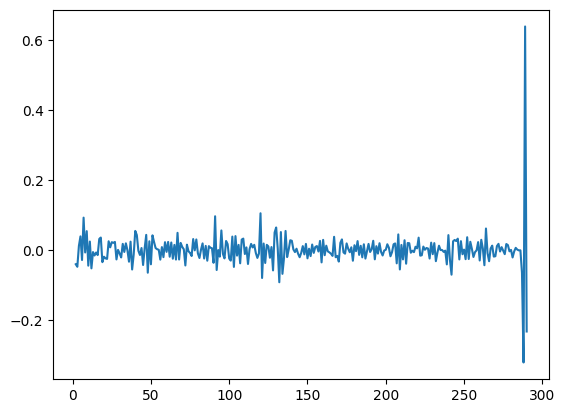

In [288]:
trans_2diff_data.plot()

In [289]:
def adf_kpss_test(data):
    # ADF Test
    adf_result = adfuller(data)
    adf_output = pd.Series(adf_result[0:4], index=['ADF Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in adf_result[4].items():
        adf_output['Critical Value (%s)'%key] = value
    adf_output['Test'] = 'ADF Test'
    
    # KPSS Test
    kpss_result = kpss(data)
    kpss_output = pd.Series(kpss_result[0:3], index=['KPSS Statistic', 'p-value', 'Number of Lags Used'])
    for key, value in kpss_result[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    kpss_output['Test'] = 'KPSS Test'
    
    # Combine the results
    result_df = pd.concat([adf_output, kpss_output], axis=0)
    
    return result_df.to_frame().T

In [290]:
adf_kpss_test(trans_2diff_data)

,ADF Statistic,p-value,Number of Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%),Test,KPSS Statistic,p-value,Number of Lags Used,Critical Value (10%),Critical Value (5%),Critical Value (2.5%),Critical Value (1%),Test
0,-7.680801,0.0,16.0,272.0,-3.454622,-2.872225,-2.572464,ADF Test,0.128852,0.1,75.0,0.347,0.463,0.574,0.739,KPSS Test


The data after transformation and 2-differencing has ADF statistics with value more negative than the critical values at all levels, and p-values smaller than 0.05. This indicates strong evidence against the null hypothesis of non-stationarity and suggests that the time series is stationary. It has KPSS statistics with p-value smaller than 0.05, which fails to reject null hypothesis of stationarity. Thus our data is stationary.

    Summarize the changes

I did Box-Cox Transformation of the time series data to stabilize the variance, and the did first and second difference of the transformed data to remove trend.

### 2. Create and interpret ACF and PACF plots

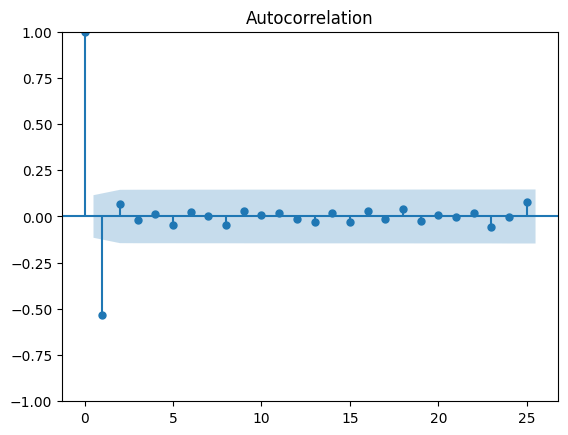

In [291]:
plot_acf(trans_2diff_data)
plt.show()

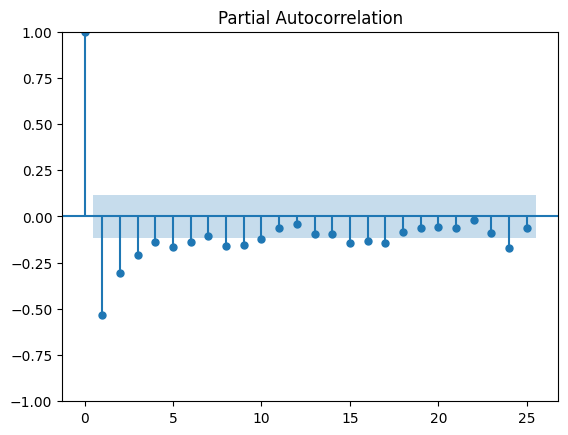

In [292]:
plot_pacf(trans_2diff_data)
plt.show()

### 3. Fit an appropriate Box Jenkins model on training set

In [293]:
y_train, y_test = train_test_split(trans_2diff_data, test_size =0.25, shuffle=False)

In [294]:
y_train.index.min(), y_train.index.max()

(2, 217)

In [295]:
y_test.index.min(), y_test.index.max()

(218, 290)

In [296]:
arma_model = ARIMA(y_train, order=(3,0,1))

In [297]:
model_fit = arma_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 497.418
Date:                Fri, 14 Apr 2023   AIC                           -982.836
Time:                        21:46:15   BIC                           -962.585
Sample:                             0   HQIC                          -974.654
                                - 216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.318e-05      0.000      0.439      0.661      -0.000       0.000
ar.L1          0.3498      0.064      5.447      0.000       0.224       0.476
ar.L2          0.1517      0.058      2.597      0.0

In [298]:
y_pred = model_fit.forecast()

<AxesSubplot: >

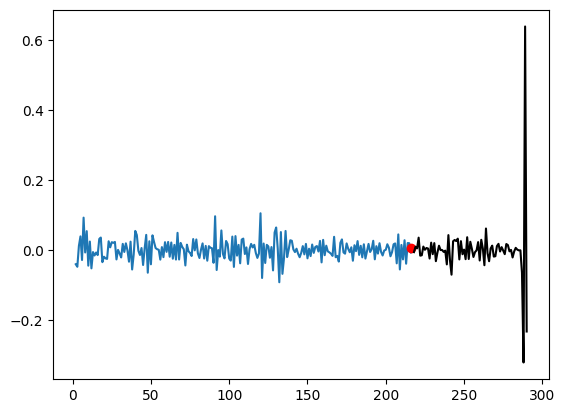

In [299]:
y_train.plot()
y_pred.plot(color='red', marker = 'o')
y_test.plot(color = 'black')

In [300]:
y_forecast = model_fit.predict(start=y_test.index.min(), end = y_test.index.max())

### 4. Check residuals (scatter plot, histogram, ACF, portmanteau tests) Give a summary of your residuals.

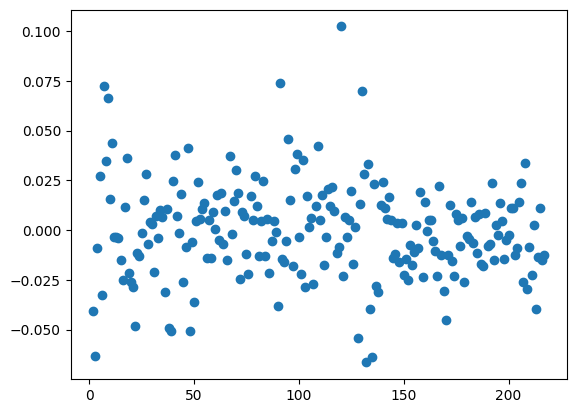

In [301]:
residuals = pd.DataFrame(model_fit.resid)
plt.scatter(residuals.index, residuals)

<AxesSubplot: ylabel='Frequency'>

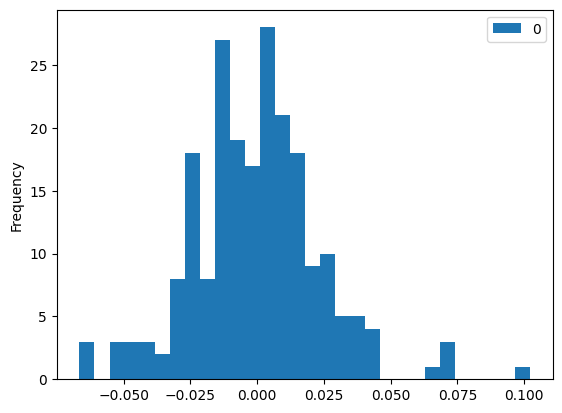

In [302]:
residuals.plot(kind='hist', bins=30)

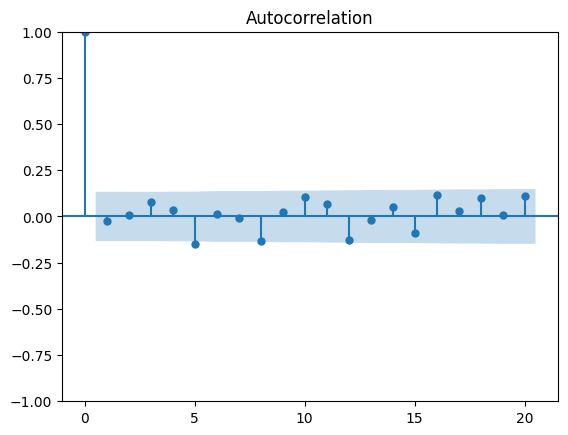

In [303]:
plot_acf(residuals, lags=20)
plt.show()

In [304]:
lb_test = acorr_ljungbox(residuals, lags=20)
lb_test

,lb_stat,lb_pvalue
1,0.132878,0.715466
2,0.149822,0.927826
3,1.539215,0.673249
4,1.781897,0.775793
5,6.841004,0.232736
6,6.875254,0.332538
7,6.897372,0.439643
8,10.737547,0.217018
9,10.853874,0.285858
10,13.329625,0.205822


    Summary analysis of residuals

We see the residuals being normally distributed with a mean of 0, indicating that the model is correctly capturing the underlying pattern in the data. Additionally, we see no significant autocorrelation in the residuals, indicating that the model is correctly accounting for all time-dependent patterns in the data. The Ljung-Box test result suggests that the residuals do not exhibit significant autocorrelation, as indicated by all the p-values being greater than 0.05. This indicates that the model is doing a good job of capturing the patterns in the data and there are no significant patterns left in the residuals. 

### 5. Print model evaluation metrics MAE, MSE, MAPE, sMAPE on test set

    Return the data to original form

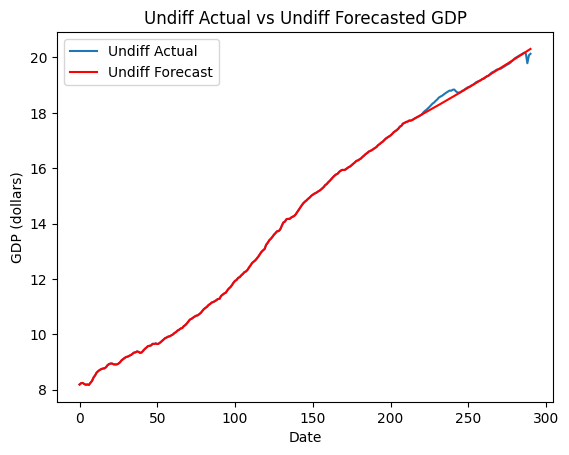

In [305]:
# Undifference twice
undiff_y = np.r_[trans_1diff_data[1], y_train, y_test].cumsum().astype('float64')
undiff_y = np.r_[trans_data[0], undiff_y].cumsum().astype('float64')
plt.plot(undiff_y, label='Undiff Actual')

# Undifference forecast
undiff_forecast = np.r_[trans_1diff_data[1], y_train, y_forecast].cumsum().astype('float64')
undiff_forecast = np.r_[trans_data[0], undiff_forecast].cumsum().astype('float64')
plt.plot(undiff_forecast, color='red', label='Undiff Forecast')

# Add a title and axis labels
plt.title('Undiff Actual vs Undiff Forecasted GDP')
plt.xlabel('Date')
plt.ylabel('GDP (dollars)')
plt.legend()

plt.show()

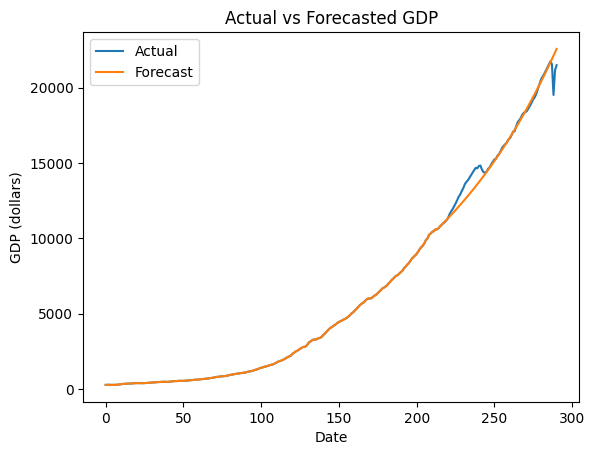

In [306]:
inv_undiff_y = inv_boxcox(undiff_y, lambda_val)
plt.plot(inv_undiff_y, label='Actual')

inv_undiff_forecast = inv_boxcox(undiff_forecast, lambda_val)
plt.plot(inv_undiff_forecast, label = 'Forecast')

# Add a title and axis labels
plt.title('Actual vs Forecasted GDP')
plt.xlabel('Date')
plt.ylabel('GDP (dollars)')
plt.legend()

plt.show()

    Evaluation metrics

In [307]:
# Calculate MAE and MSE
mae = mean_absolute_error(y_test, inv_undiff_forecast[218:])
mse = mean_squared_error(y_test, inv_undiff_forecast[218:])

# Calculate MAPE and sMAPE
mape = mean_absolute_percentage_error(y_test, inv_undiff_forecast[218:])
smape = np.mean(2.0 * np.abs(inv_undiff_forecast[218:] - y_test) / (np.abs(y_test) + np.abs(inv_undiff_forecast[218:]))) * 100

# Print the results
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)
print("sMAPE:", smape)

MAE: 16117.631091336647
MSE: 270941964.90429074
MAPE: 8215918.091603472
sMAPE: 199.99962954915847


## Part 3 – Box Jenkins model for Unemployment rate

### 1. Perform transformations or differencing until you can visually and statistically confirm stationarity on training set. Summarize the changes to your time series.

<AxesSubplot: xlabel='date'>

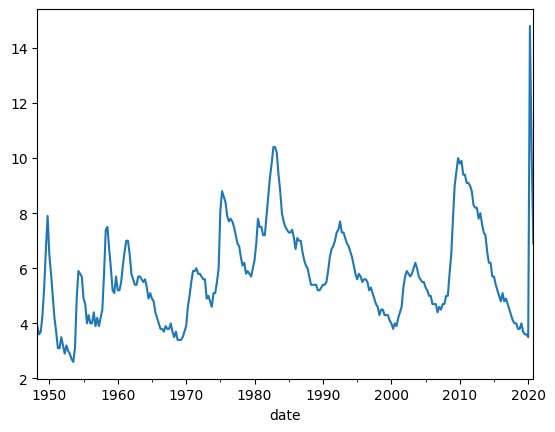

In [308]:
urate = data['urate']
urate.plot()

In [335]:
urate

date
1948-04-01     3.9
1948-07-01     3.6
1948-10-01     3.7
1949-01-01     4.3
1949-04-01     5.3
              ... 
2019-10-01     3.6
2020-01-01     3.5
2020-04-01    14.8
2020-07-01    10.2
2020-10-01     6.9
Name: urate, Length: 291, dtype: float64

In [309]:
trans_data, lambda_val = stats.boxcox(urate)
trans_data = pd.Series(trans_data)

In [310]:
trans_diff_data = (trans_data-trans_data.shift()).iloc[1:]

<AxesSubplot: >

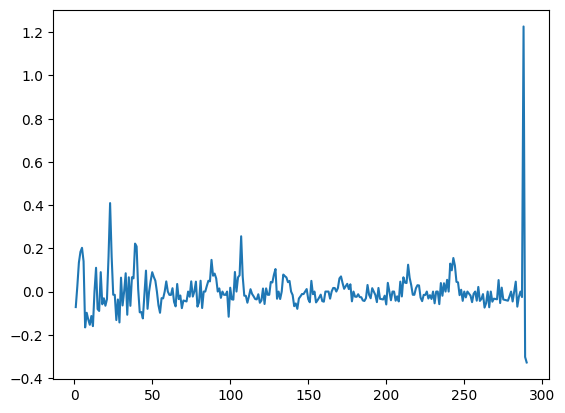

In [311]:
trans_diff_data.plot()

In [313]:
adf_kpss_test(trans_diff_data)

,ADF Statistic,p-value,Number of Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%),Test,KPSS Statistic,p-value,Number of Lags Used,Critical Value (10%),Critical Value (5%),Critical Value (2.5%),Critical Value (1%),Test
0,-15.256106,0.0,0.0,289.0,-3.453182,-2.871593,-2.572127,ADF Test,0.023214,0.1,0.0,0.347,0.463,0.574,0.739,KPSS Test


The data after transformation and 1-differencing has ADF statistics with value more negative than the critical values at all levels, and p-values smaller than 0.05. This indicates strong evidence against the null hypothesis of non-stationarity and suggests that the time series is stationary. It has KPSS statistics with p-value smaller than 0.05, which fails to reject null hypothesis of stationarity. Thus our data is stationary.

    Summarize the changes

I did Box-Cox Transformation of the time series data to stabilize the variance, and then did first difference of the transformed data to remove trend.

### 2. Create and interpret ACF and PACF plots

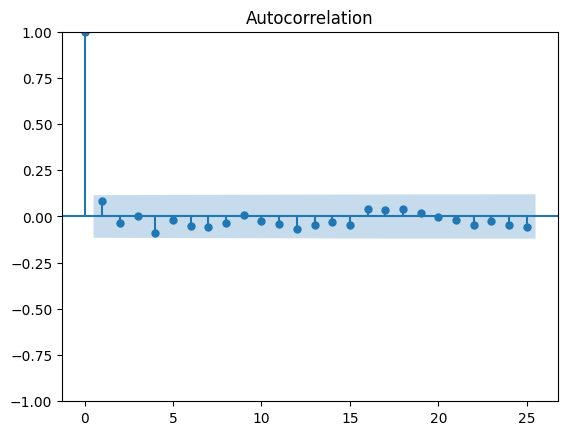

In [314]:
plot_acf(trans_diff_data)
plt.show()

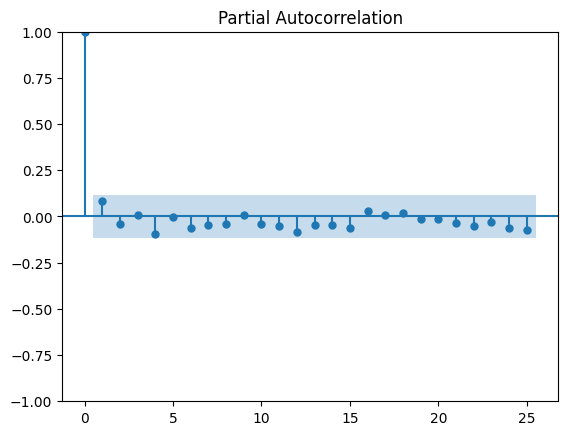

In [315]:
plot_pacf(trans_diff_data)
plt.show()

### 3. Fit an appropriate Box Jenkins model on training set

In [316]:
y_train, y_test = train_test_split(trans_diff_data, test_size =0.25, shuffle=False)

In [317]:
y_train.index.min(), y_train.index.max()

(1, 217)

In [318]:
y_test.index.min(), y_test.index.max()

(218, 290)

In [319]:
arma_model = ARIMA(y_train, order=(4,0,4))

In [320]:
model_fit = arma_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  217
Model:                 ARIMA(4, 0, 4)   Log Likelihood                 296.909
Date:                Fri, 14 Apr 2023   AIC                           -573.817
Time:                        21:46:27   BIC                           -540.018
Sample:                             0   HQIC                          -560.164
                                - 217                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.004     -0.160      0.873      -0.009       0.007
ar.L1          0.1363      0.261      0.523      0.601      -0.374       0.647
ar.L2          0.7447      0.207      3.600      0.0

In [321]:
y_pred = model_fit.forecast()

<AxesSubplot: >

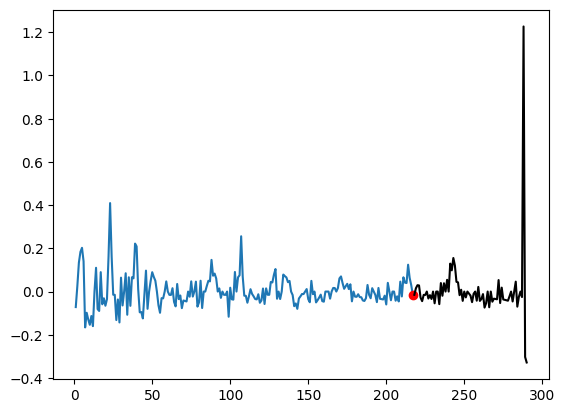

In [322]:
y_train.plot()
y_pred.plot(color='red', marker = 'o')
y_test.plot(color = 'black')

In [323]:
y_forecast = model_fit.predict(start=y_test.index.min(), end = y_test.index.max())

In [324]:
y_train, y_test = train_test_split(trans_diff_data, test_size =0.25, shuffle=False)

In [325]:
y_train.index.min(), y_train.index.max()

(1, 217)

In [326]:
y_test.index.min(), y_test.index.max()

(218, 290)

### 4. Check residuals (scatter plot, histogram, ACF, portmanteau tests) Give a summary of your residuals.

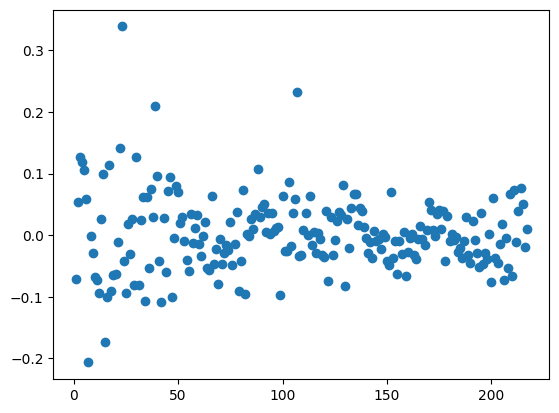

In [327]:
residuals = pd.DataFrame(model_fit.resid)
plt.scatter(residuals.index, residuals)

<AxesSubplot: ylabel='Frequency'>

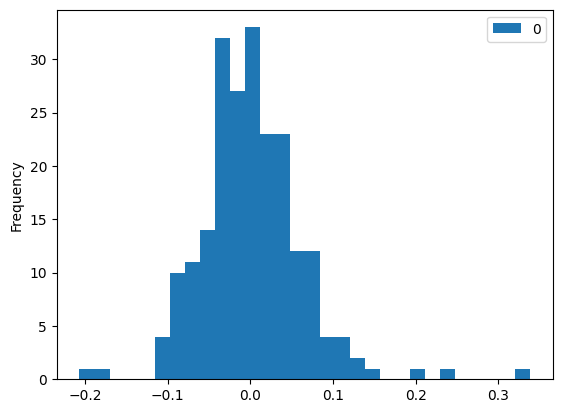

In [328]:
residuals.plot(kind='hist', bins=30)

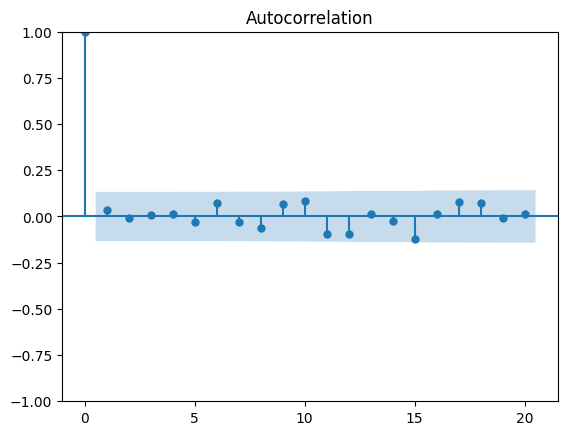

In [329]:
plot_acf(residuals, lags=20)
plt.show()

In [330]:
lb_test = acorr_ljungbox(residuals, lags=20)
lb_test

,lb_stat,lb_pvalue
1,0.264634,0.606954
2,0.279656,0.869508
3,0.294717,0.961019
4,0.344202,0.986785
5,0.520923,0.991337
6,1.679958,0.946658
7,1.875805,0.966393
8,2.816445,0.945343
9,3.889771,0.918516
10,5.520348,0.853825


    Summary

We see the residuals being normally distributed with a mean of 0, indicating that the model is correctly capturing the underlying pattern in the data. Additionally, we see no significant autocorrelation in the residuals, indicating that the model is correctly accounting for all time-dependent patterns in the data. The Ljung-Box test result suggests that the residuals do not exhibit significant autocorrelation, as indicated by all the p-values being greater than 0.05. This indicates that the model is doing a good job of capturing the patterns in the data and there are no significant patterns left in the residuals. 

### 5. Print model evaluation metrics MAE, MSE, MAPE, sMAPE on test set

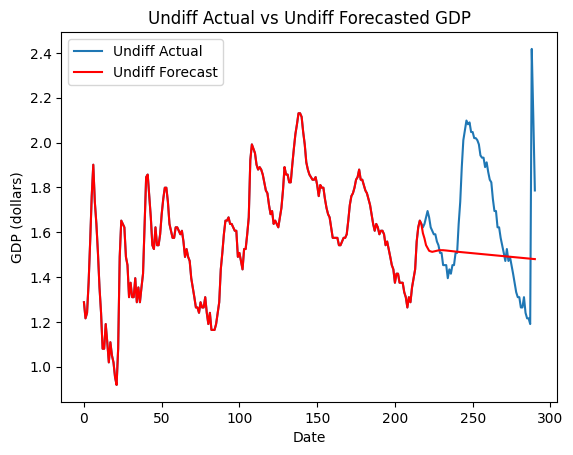

In [331]:
undiff_y = np.r_[trans_data[0], y_train, y_test].cumsum().astype('float64')
plt.plot(undiff_y, label='Undiff Actual')

undiff_forecast = np.r_[trans_data[0], y_train,  y_forecast].cumsum().astype('float64')
plt.plot(undiff_forecast, color='red', label='Undiff Forecast')


# Add a title and axis labels
plt.title('Undiff Actual vs Undiff Forecasted GDP')
plt.xlabel('Date')
plt.ylabel('GDP (dollars)')
plt.legend()

plt.show()

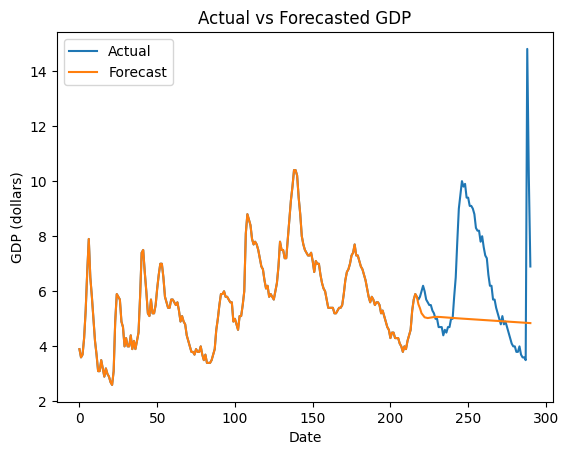

In [332]:
inv_undiff_y = inv_boxcox(undiff_y, lambda_val)
plt.plot(inv_undiff_y, label='Actual')

inv_undiff_forecast = inv_boxcox(undiff_forecast, lambda_val)
plt.plot(inv_undiff_forecast, label = 'Forecast')

# Add a title and axis labels
plt.title('Actual vs Forecasted GDP')
plt.xlabel('Date')
plt.ylabel('GDP (dollars)')
plt.legend()

plt.show()

In [333]:
# Calculate MAE and MSE
mae = mean_absolute_error(y_test, inv_undiff_forecast[218:])
mse = mean_squared_error(y_test, inv_undiff_forecast[218:])

# Calculate MAPE and sMAPE
mape = mean_absolute_percentage_error(y_test, inv_undiff_forecast[218:])
smape = np.mean(2.0 * np.abs(inv_undiff_forecast[218:] - y_test) / (np.abs(y_test) + np.abs(inv_undiff_forecast[218:]))) * 100

# Print the results
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)
print("sMAPE:", smape)

MAE: 4.984078530510662
MSE: 24.878655807740053
MAPE: 4302590836141127.0
sMAPE: 197.88342773290734


## Part 4 – Evaluation Compare the two models’ performance using the error metrics as evidence

Based on the given evaluation metrics, the ARIMA model may not be performing well on the GDP dataset. The high values of MAE, MSE, MAPE, and sMAPE suggest that the model's predictions are far from the actual values. It is important to note that these evaluation metrics should be interpreted in the context of the specific problem and domain knowledge. Further analysis and model tuning may be necessary to improve the performance of the ARIMA model.

The ARIMA model seems to perform better on the unemployment rate data than the GDP data. The MAE and MSE values are much lower for the unemployment rate data, indicating that the model's predictions are closer to the actual values. However, the MAPE and sMAPE values are still quite high, which suggests that the model's predictions may not be very accurate for certain periods or at extreme values. It may be worthwhile to try different models or adjust the ARIMA model parameters to further improve its performance.